# Data Preparation and import

In [11]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import shap
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RationalQuadratic, ConstantKernel,WhiteKernel
from sklearn.kernel_ridge import KernelRidge

In [13]:
# Importing the dataset
data0 = pd.read_excel('/content/sample_data/PNNL data_FinalCurated.xlsx', sheet_name ='Initial set')
data0 = data0[["crystal radius",'Pauling Electronegativity','FE','OE',
          'valence s','valence p',"valence d",'valence f','specific heat',
          "thermal conductivity","Cohesive energy",
          "GHSV","H2CO","Temp", 'F_STY']]

In [14]:
X = data0[["crystal radius",'Pauling Electronegativity','FE','OE',
          'valence s','valence p',"valence d",'valence f','specific heat',
          "thermal conductivity","Cohesive energy",
          "GHSV","H2CO","Temp"]]

y = data0['F_STY']

# Function definition

In [ ]:
## Funtions for Confidence interval

## Creat Boostrap samples
def bootstrap_samples(X, n_samples):
    bootstrap_samples = []

    for j in range(n_samples):
        np.random.seed(j)# For reproducible
        indices = np.random.choice(len(X), size=len(X), replace=True)
        sampled_data = X.iloc[indices, :]
        bootstrap_samples.append(sampled_data)

    return bootstrap_samples

## Calculate CI
def Confidence_interval(confidence_level, samples, trained_model):
  shapley = pd.DataFrame(np.zeros((len(samples), 14)))
  CI_df  = pd.DataFrame(np.zeros((14, 2)))

  lower_percentile = (1 - confidence_level) / 2 * 100
  upper_percentile = (1 + confidence_level) / 2 * 100

  for i in range(len(samples)):
    explainer = shap.Explainer(trained_model, samples[i], explainer_type="linear")
    shap_values = explainer(samples[i])
    shapley.iloc[i,] = abs(pd.DataFrame(shap_values.values)).mean()

  for j in range(14):
    CI_df.iloc[j,0] = np.percentile(shapley[j], 2.5)
    CI_df.iloc[j,1] = np.percentile(shapley[j], 97.5)

  CI_df.columns = ['Lower_Bound', 'Upper_Bound']
  CI_df['Interval_len'] = CI_df['Upper_Bound'] - CI_df['Lower_Bound']
  CI_df['Mean'] = shapley.mean()
  CI_df['Names'] = list(samples[0].columns)
  return CI_df.sort_values(by='Mean', ascending=False), shapley

## Plot CI  
def Plotting_CI(df):
  fig, ax = plt.subplots(figsize=(15,7))
  ax.errorbar(x=df["Mean"],
            y=np.arange(14),
            xerr=np.array(df['Interval_len']) ,
            fmt='o', capsize=5, color='black')
  plt.yticks(np.arange(14), df['Names'])
  ax.set_ylim(ax.get_ylim()[::-1])
  plt.xlabel('SHAP Value CI')
  plt.ylabel('Variable Name')
  plt.rc('font', size=13)
  plt.show()

In [ ]:
#Create 1000 bootstrap samples for confidence interval calculation
Xt, X_test, yt, y_test = train_test_split(X, y, test_size = 0.15, random_state = 0)
Sample = bootstrap_samples(Xt,1000)

# OLS method

In [ ]:
## Model fit
model_OLS = LinearRegression()
model_OLS.fit(Xt, yt)

#Measure the R2 for training and test set
print("The training R2 is: ", model_OLS.score(Xt, yt))
print("The test R2 is: ", model_OLS.score(X_test, y_test))

y_predicted_train = model_OLS.predict(Xt)
y_predicted_test = model_OLS.predict(X_test)

# The mean squared error & Variance
print("MSE of train set: %.2f"% mean_squared_error(yt, y_predicted_train))
print("RMSE of train set: %.2f"% sqrt(mean_squared_error(yt, y_predicted_train)))

print("MSE of test set: %.2f"% mean_squared_error(y_test, y_predicted_test))
print("RMSE of test set: %.2f"% sqrt(mean_squared_error(y_test, y_predicted_test)))

#k-cross validation
scores = cross_validate(estimator = model_OLS, X=X, y=y, cv=10, scoring=('r2'), return_train_score=True)
accuracies = cross_val_score(estimator = model_OLS, X = X, y= y, cv=5)
#print("The mean accuracy is: ", accuracies.mean())
print(scores)

The training R2 is:  0.39772384008349304
The test R2 is:  0.6333626722917192
MSE of train set: 254.49
RMSE of train set: 15.95
MSE of test set: 144.02
RMSE of test set: 12.00
{'fit_time': array([0.00424314, 0.00373816, 0.00342727, 0.00355172, 0.00689197,
       0.00587654, 0.00392127, 0.00330734, 0.00434804, 0.00485802]), 'score_time': array([0.00205159, 0.00214624, 0.00194526, 0.00286126, 0.00409126,
       0.00273633, 0.0020628 , 0.00195718, 0.00229955, 0.00208545]), 'test_score': array([-5.90522733e+02, -1.19132159e+00,  1.14203669e-01, -1.26097681e-01,
       -8.93934079e-02, -1.22726053e-01,  6.80519636e-01,  5.80939545e-01,
       -1.52056845e+00, -8.08603463e+01]), 'train_score': array([0.476988  , 0.45040119, 0.48460382, 0.47592972, 0.48037657,
       0.41102582, 0.41193013, 0.41393974, 0.49568165, 0.50895604])}


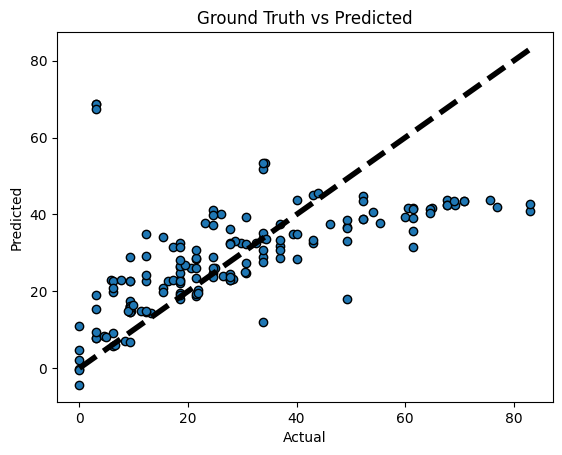

In [ ]:
fig, ax = plt.subplots()
ax.scatter(yt, y_predicted_train, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Ground Truth vs Predicted")
plt.show()

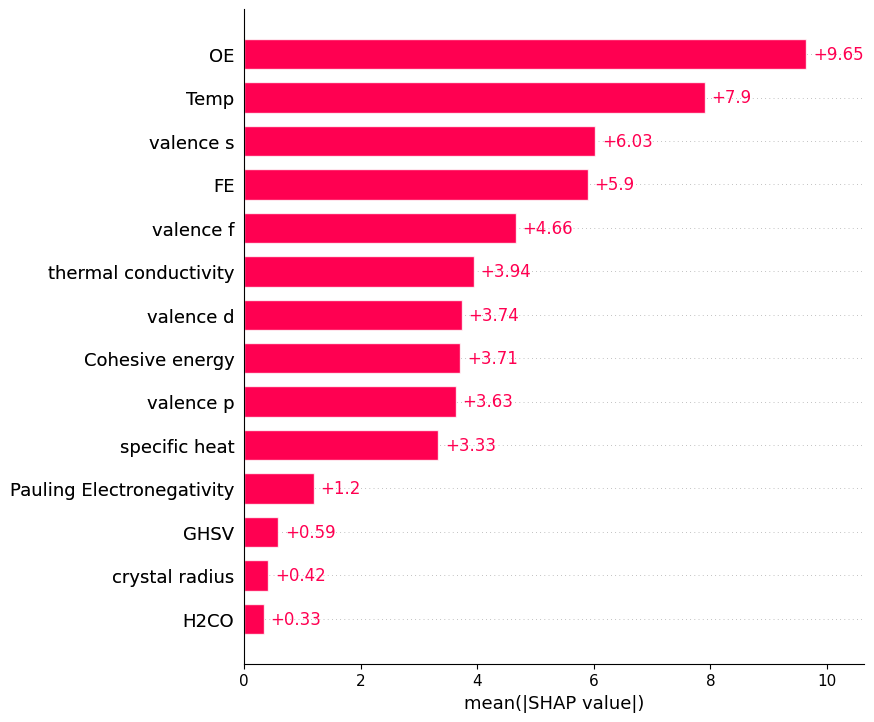

In [ ]:
explainer = shap.Explainer(model_OLS, X, explainer_type="linear")
shap_values = explainer(Xt)

shap.plots.bar(shap_values, max_display=15)

In [ ]:
df1, df2 = Confidence_interval(confidence_level=0.95, samples = Sample, trained_model = model_OLS)

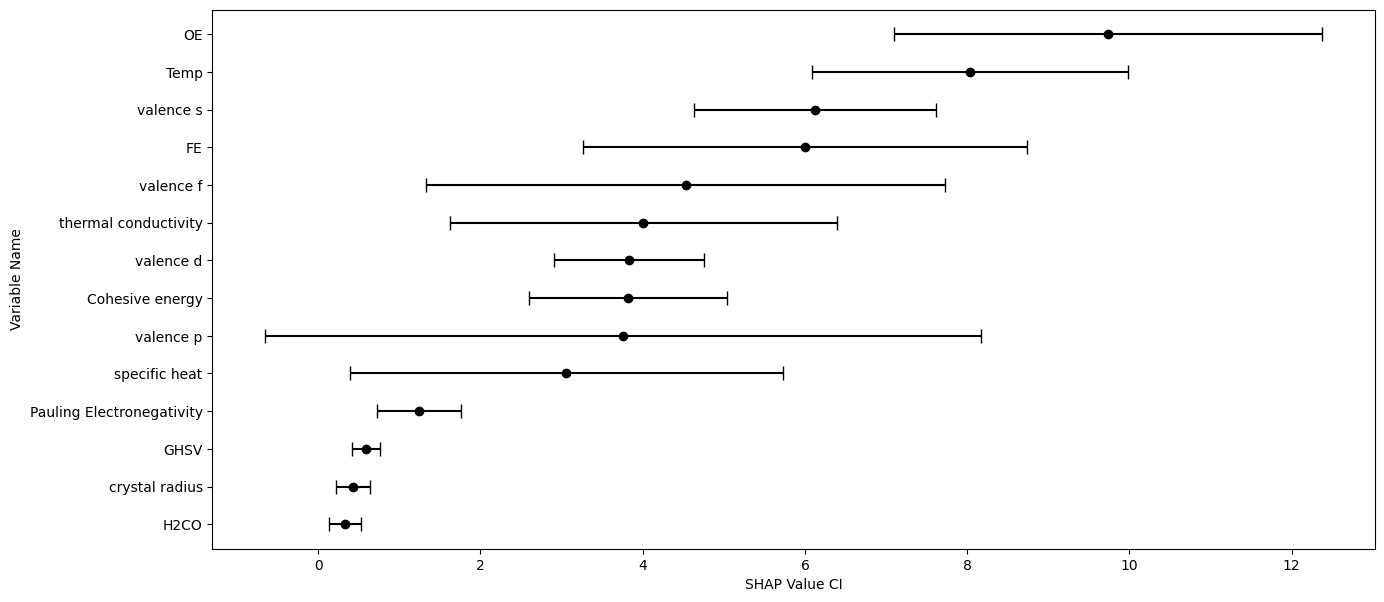

In [ ]:
Plotting_CI(df1)

In [ ]:
## Confidence interval for OLS(shap values)
df1

,Lower_Bound,Upper_Bound,Interval_len,Mean,Names
3,8.397644,11.034039,2.636395,9.737301,OE
13,7.065860,9.013863,1.948002,8.035218,Temp
4,5.289636,6.781300,1.491664,6.118872,valence s
2,4.647394,7.382797,2.735402,5.995572,FE
7,2.916311,6.117791,3.201480,4.529400,valence f
9,2.931333,5.315250,2.383918,4.007855,thermal conductivity
6,3.336843,4.257414,0.920571,3.832988,valence d
10,3.226680,4.447473,1.220793,3.820145,Cohesive energy
5,1.820746,6.228869,4.408123,3.755674,valence p
8,1.764799,4.434851,2.670052,3.059543,specific heat


In [ ]:
df1.to_csv('CI_OLS.csv', index=False)

# Lasso Regression(L1)

In [ ]:
#Grid search for L1
model_Lasso = Lasso()


param_grid={'alpha':np.arange(0,100,0.2).tolist()}


tuning = GridSearchCV(estimator=model_Lasso, 
                          param_grid = param_grid,
                          cv=10,
                          verbose=1,
                          n_jobs=-1)
    
tuning.fit(X, y)

print("Best parameters:")
print(tuning.best_params_)

Fitting 10 folds for each of 500 candidates, totalling 5000 fits
Best parameters:
{'alpha': 2.8000000000000003}


In [ ]:
# Fitting Lasso Regression with optimized parameters
model_Lasso = Lasso(alpha = 2.8)
model_Lasso.fit(Xt, yt)

#Measure the R2 for training and test set
print("The training R2 is: ", model_Lasso.score(Xt, yt))
print("The test R2 is: ", model_Lasso.score(X_test, y_test))

y_predicted_train = model_Lasso.predict(Xt)
y_predicted_test = model_Lasso.predict(X_test)

# The mean squared error & Variance
print("MSE of train set: %.2f"% mean_squared_error(yt, y_predicted_train))
print("RMSE of train set: %.2f"% sqrt(mean_squared_error(yt, y_predicted_train)))

print("MSE of test set: %.2f"% mean_squared_error(y_test, y_predicted_test))
print("RMSE of test set: %.2f"% sqrt(mean_squared_error(y_test, y_predicted_test)))


The training R2 is:  0.33750010173147615
The test R2 is:  0.5585858385699927
MSE of train set: 279.94
RMSE of train set: 16.73
MSE of test set: 173.40
RMSE of test set: 13.17


In [ ]:
print("The mean accuracy is: ", accuracies.mean())
accuracies

The mean accuracy is:  0.3304325041427708


array([0.20366339, 0.023495  , 0.42251479, 0.52928143, 0.47320791])

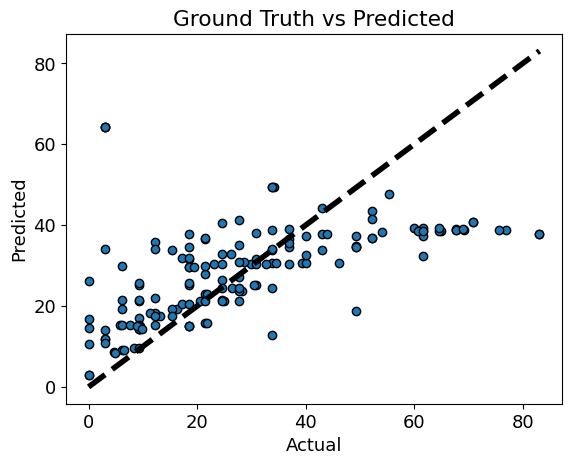

In [ ]:
fig, ax = plt.subplots()
ax.scatter(yt, y_predicted_train, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Ground Truth vs Predicted")
plt.show()

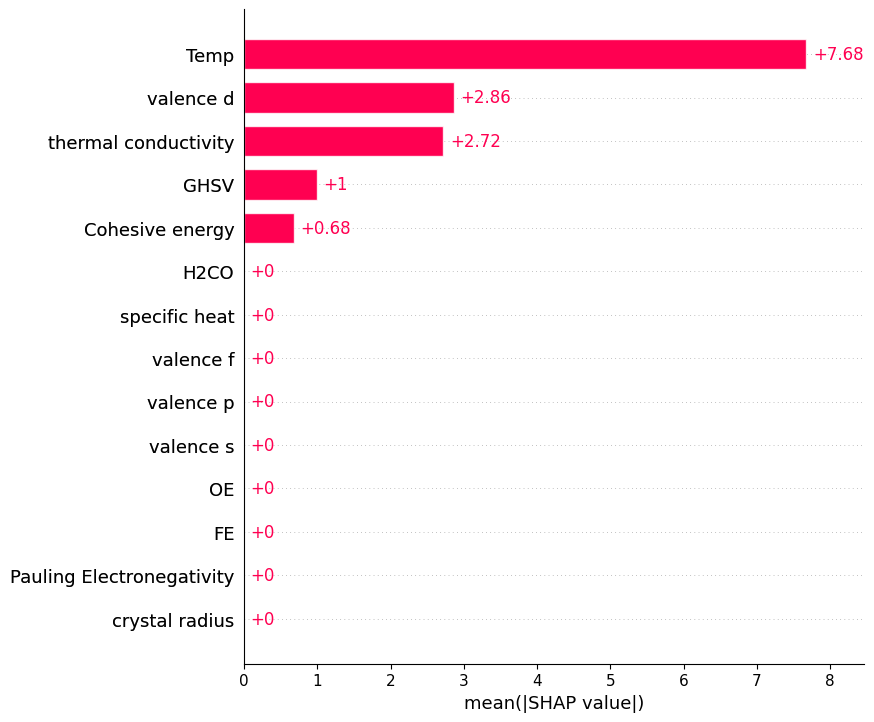

In [ ]:
explainer = shap.Explainer(model_Lasso, Xt, explainer_type="linear")
shap_values = explainer(Xt)

shap.plots.bar(shap_values, max_display=15)

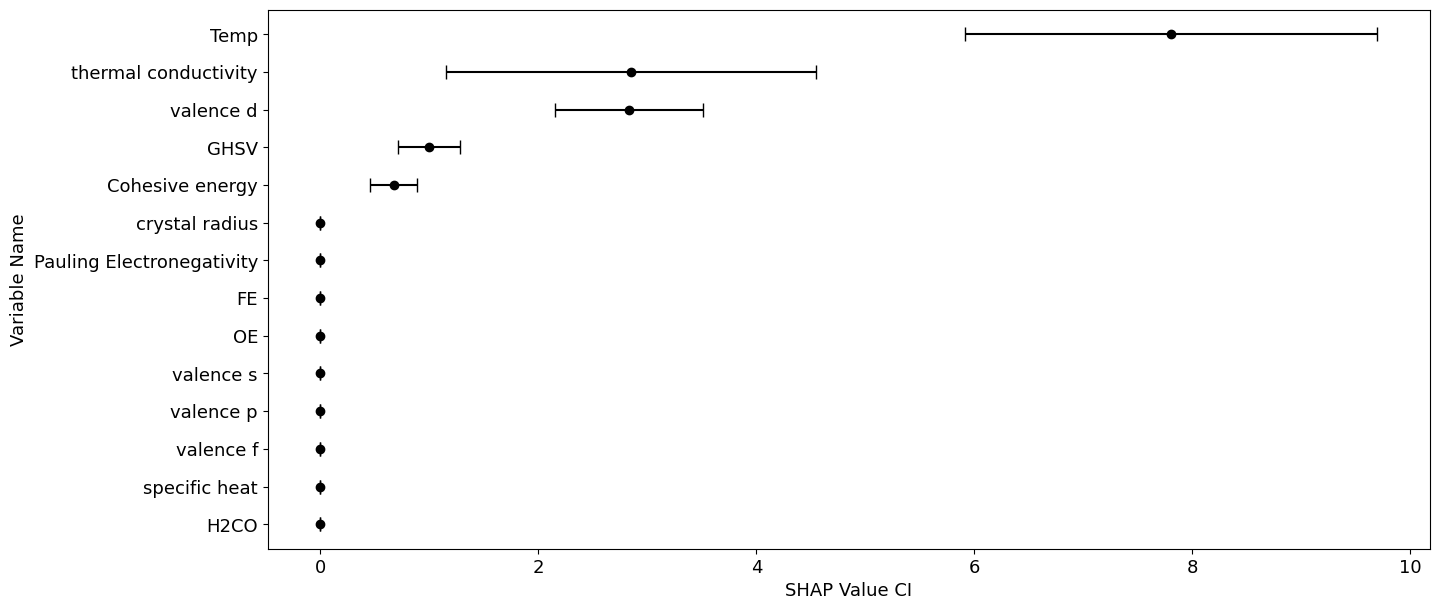

In [ ]:
df3, df4 = Confidence_interval(confidence_level=0.95, samples = Sample, trained_model = model_Lasso)
Plotting_CI(df3)

In [ ]:
## Confidence interval for Lasso(shap values)
df3

,Lower_Bound,Upper_Bound,Interval_len,Mean,Names
13,6.862310,8.754195,1.891885,7.803743,Temp
9,2.086035,3.782512,1.696477,2.852125,thermal conductivity
6,2.462037,3.141266,0.679229,2.828110,valence d
11,0.844627,1.128241,0.283614,0.993320,GHSV
10,0.567052,0.781592,0.214540,0.671347,Cohesive energy
0,0.000000,0.000000,0.000000,0.000000,crystal radius
1,0.000000,0.000000,0.000000,0.000000,Pauling Electronegativity
2,0.000000,0.000000,0.000000,0.000000,FE
3,0.000000,0.000000,0.000000,0.000000,OE
4,0.000000,0.000000,0.000000,0.000000,valence s


# Ridge Regression(L2)

In [ ]:
#Grid search for L2
model_Ridge = Ridge()

param_grid={'alpha':np.arange(0,100,1).tolist()}

tuning = GridSearchCV(estimator=model_Ridge, 
                          param_grid = param_grid,
                          cv=63,
                          verbose=1,
                          n_jobs=-1)
    
tuning.fit(X, y)

print("Best parameters:")
print(tuning.best_params_)

Fitting 63 folds for each of 100 candidates, totalling 6300 fits
Best parameters:
{'alpha': 12}


In [ ]:
model_Ridge = Ridge(alpha = 12)
model_Ridge.fit(Xt, yt)

#Measure the R2 for training and test set
model_score = model_Ridge.score(Xt, yt)

print("The training R2 is: ", model_score)
print("The test R2 is: ", model_Ridge.score(X_test, y_test))

y_predicted_train = model_Ridge.predict(Xt)
y_predicted_test = model_Ridge.predict(X_test)

# The mean squared error & Variance
print("MSE of train set: %.2f"% mean_squared_error(yt, y_predicted_train))
print("RMSE of train set: %.2f"% sqrt(mean_squared_error(yt, y_predicted_train)))

print("MSE of test set: %.2f"% mean_squared_error(y_test, y_predicted_test))
print("RMSE of test set: %.2f"% sqrt(mean_squared_error(y_test, y_predicted_test)))

The training R2 is:  0.3858781901657402
The test R2 is:  0.6042709577544727
MSE of train set: 259.49
RMSE of train set: 16.11
MSE of test set: 155.45
RMSE of test set: 12.47


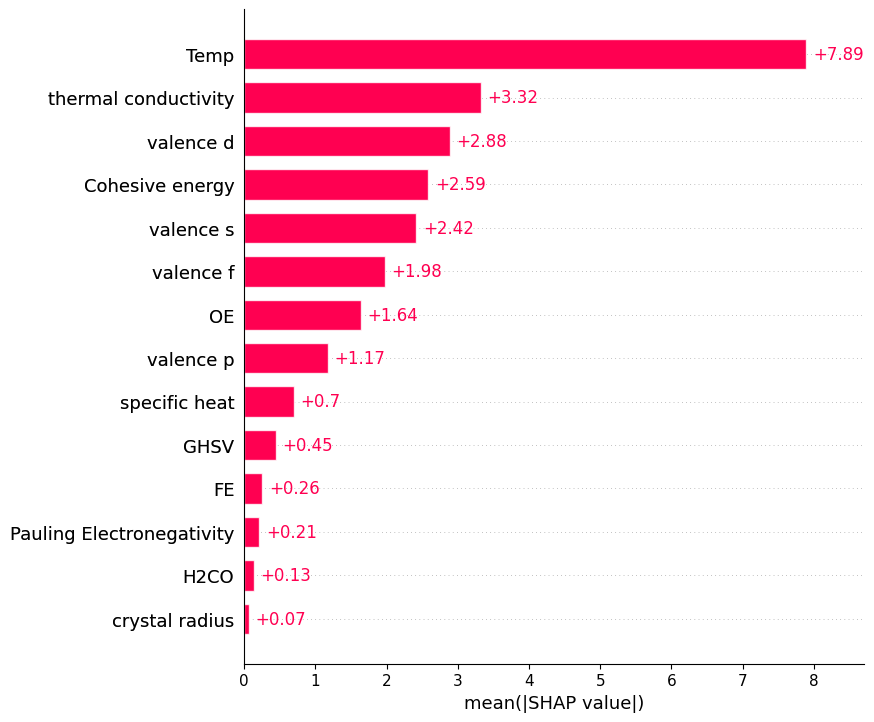

In [ ]:
explainer = shap.Explainer(model_Ridge, Xt, explainer_type="linear")
shap_values = explainer(Xt)

shap.plots.bar(shap_values, max_display=15)

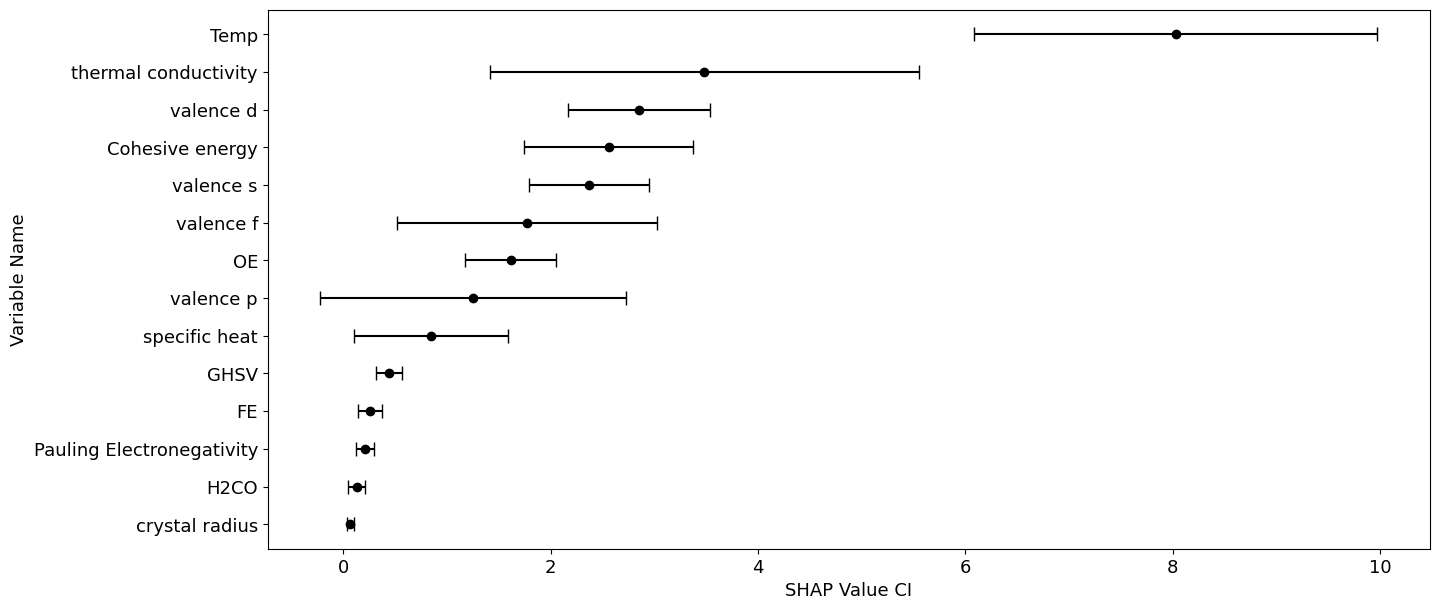

In [ ]:
df5, df6 = Confidence_interval(confidence_level=0.95, samples = Sample, trained_model = model_Ridge)
Plotting_CI(df5)

In [ ]:
## Confidence interval for Lasso(shap values)
df5

,Lower_Bound,Upper_Bound,Interval_len,Mean,Names
13,7.057539,9.003247,1.945708,8.025755,Temp
9,2.547970,4.620117,2.072147,3.483704,thermal conductivity
6,2.482770,3.167718,0.684949,2.851925,valence d
10,2.161976,2.979946,0.817969,2.559617,Cohesive energy
4,2.048357,2.625988,0.577631,2.369470,valence s
7,1.139942,2.391352,1.251410,1.770474,valence f
3,1.391784,1.828728,0.436943,1.613813,OE
5,0.609148,2.083929,1.474780,1.256498,valence p
8,0.490676,1.233043,0.742368,0.850660,specific heat
11,0.377719,0.504552,0.126833,0.444215,GHSV


# MLP(Bad Results)

## Import

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torch.nn.init as init
import random

## Data preparation

In [ ]:
# Data transformation and segmentation for cv
DF = data0.sample(frac=1, random_state=1).reset_index(drop=True)

data_vali_list, data_train_list, Feature_train_list, label_train_list = [], [], [], []
Feature_vali_list, label_vali_list, dataloader_vali_list, dataloader_train_list = [], [], [], []
Torch_train_list, Torch_vali_F_list, Torch_vali_L_list, Torch_train_F_list, Torch_train_L_list = [], [], [], [], []

for i in range(5):
    index = 38
    if i == 4:
      index = 37
    data_vali_list.append(DF.iloc[i*index:(i+1)*index,])
    data_train_list.append(DF.drop(range(i*index,(i+1)*index)))

    label_vali_list.append(data_vali_list[i]['F_STY'].values)
    Feature_vali_list.append(data_vali_list[i].drop('F_STY', axis = 1).values)

    label_train_list.append(data_train_list[i]['F_STY'].values)
    Feature_train_list.append(data_train_list[i].drop('F_STY', axis = 1).values)
    
    torch_Train_labels = torch.LongTensor(label_train_list[i])
    torch_Train_features = torch.FloatTensor(Feature_train_list[i])

    dataset_train = torch.utils.data.TensorDataset(torch_Train_features, torch_Train_labels)
    
    torch_Test_labels = torch.LongTensor(label_vali_list[i])
    torch_Test_features = torch.FloatTensor(Feature_vali_list[i])

    Torch_train_list.append(torch.utils.data.DataLoader(dataset_train, batch_size=32))
    Torch_vali_F_list.append(torch_Test_features)
    Torch_vali_L_list.append(torch_Test_labels)
    Torch_train_F_list.append(torch_Train_features)
    Torch_train_L_list.append(torch_Train_labels)

In [ ]:
# Prepare for model training data
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 0)

dataset_train_new = torch.utils.data.TensorDataset(torch.FloatTensor(X_train.values), 
                           torch.FloatTensor(y_train.values.reshape(-1, 1)))
Torch_train = torch.utils.data.DataLoader(dataset_train_new, batch_size=32)

Test_L = y_test
Torch_test_F = torch.FloatTensor(X_test.values)

In [ ]:
#Class definition
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, ac_func = torch.relu,
                 dropout = False, dropout_rate=0, Batch_norm=False, set_seed = 1):

        super(MLP, self).__init__()
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.ac_func = ac_func
        self.dropout_rate = dropout_rate
        self.dropt = dropout
        self.Batchn = Batch_norm
        self.bn = nn.BatchNorm1d(hidden_sizes[0])

        # Input layer
        self.input_layer = nn.Linear(input_size, hidden_sizes[0]) #[15,15,15]
        
        # Hidden layers (-1: becasue last layer connects to output and we always have same number of units in the list)
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_sizes) - 1):
            self.hidden_layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
        
        # Output layer
        self.output_layer = nn.Linear(hidden_sizes[-1], 1)
        
        # Dropout
        if dropout == False:
           dropout_rate = 0

        self.dropout = nn.Dropout(p=dropout_rate)

        #Parameter initialization
        torch.manual_seed(set_seed)
        init.xavier_uniform_(self.input_layer.weight)
        for layer in self.hidden_layers:
          torch.manual_seed(set_seed)
          init.xavier_uniform_(layer.weight)
        torch.manual_seed(set_seed)
        init.xavier_uniform_(self.output_layer.weight)

    def forward(self, x):
        torch.manual_seed(1)
        x = torch.relu(self.input_layer(x))

        if self.dropt == True:
           for i in range(len(self.hidden_sizes) - 1):
               torch.manual_seed(1)
               x = self.dropout(x)
               x = self.ac_func(self.hidden_layers[i](x))
           torch.manual_seed(1)
           x = self.dropout(x)
           x = self.output_layer(x)
        elif self.Batchn == True:
           for i in range(len(self.hidden_sizes) - 1):
               x = self.ac_func(self.hidden_layers[i](x))
               x = self.bn(x)
           x = self.output_layer(x)
        else:
            for i in range(len(self.hidden_sizes) - 1):
               x = self.ac_func(self.hidden_layers[i](x))
            x = self.output_layer(x)

        return x

# Function of return cross validation score of given model.
def MLP_regression(input_s=14, hidden_s=[], ac_fun = torch.relu,
                 dropt = False, dropout_r=0.0, Batch_Normal = False, patience = 10, max_epoch = 1000, seed = 1,
                 Train_data = Torch_train_list, Test_F = Torch_vali_F_list, Test_L = Torch_vali_L_list,
                 Train_F = Torch_train_F_list, Train_L = Torch_train_L_list, 
                 st = 35, learn_rate = 0.001, regularization_strength = 0):
  
    cv_score = []
    train_score = []
    counter = 0
    best_cv_score = 100000000
    # Models for CV
    torch.manual_seed(seed)
    MLPC1 = MLP(input_size=input_s, hidden_sizes=hidden_s, ac_func = ac_fun,
            dropout = dropt, dropout_rate=dropout_r, Batch_norm=Batch_Normal, set_seed = seed)
    optimizer1 = optim.Adam(MLPC1.parameters(), lr=learn_rate, weight_decay=regularization_strength)
    criterion1 = nn.MSELoss()
    scheduler1 = lr_scheduler.StepLR(optimizer1, step_size=st, gamma=0.1)

    MLPC2 = MLP(input_size=input_s, hidden_sizes=hidden_s, ac_func = ac_fun,
            dropout = dropt, dropout_rate=dropout_r, Batch_norm=Batch_Normal, set_seed = seed)
    optimizer2 = optim.Adam(MLPC2.parameters(), lr=learn_rate, weight_decay=regularization_strength)
    criterion2 = nn.MSELoss()
    scheduler2 = lr_scheduler.StepLR(optimizer2, step_size=st, gamma=0.1)

    MLPC3 = MLP(input_size=input_s, hidden_sizes=hidden_s, ac_func = ac_fun,
            dropout = dropt, dropout_rate=dropout_r, Batch_norm=Batch_Normal, set_seed = seed)
    optimizer3 = optim.Adam(MLPC3.parameters(), lr=learn_rate, weight_decay=regularization_strength)
    criterion3 = nn.MSELoss()
    scheduler3 = lr_scheduler.StepLR(optimizer3, step_size=st, gamma=0.1)

    MLPC4 = MLP(input_size=input_s, hidden_sizes=hidden_s, ac_func = ac_fun,
            dropout = dropt, dropout_rate=dropout_r, Batch_norm=Batch_Normal, set_seed = seed)
    optimizer4 = optim.Adam(MLPC4.parameters(), lr=learn_rate, weight_decay=regularization_strength)
    criterion4 = nn.MSELoss()
    scheduler4 = lr_scheduler.StepLR(optimizer4, step_size=st, gamma=0.1)

    MLPC5 = MLP(input_size=input_s, hidden_sizes=hidden_s, ac_func = ac_fun,
            dropout = dropt, dropout_rate=dropout_r, Batch_norm=Batch_Normal, set_seed = seed)
    optimizer5 = optim.Adam(MLPC5.parameters(), lr=learn_rate, weight_decay=regularization_strength)
    criterion5 = nn.MSELoss()
    scheduler5 = lr_scheduler.StepLR(optimizer5, step_size=st, gamma=0.1)

    # CV data
    for epoch in range(max_epoch):
        run_score = []
        run_train = []
        MLPC1.train
        torch.manual_seed(1)
        for batch_idx1, (data1, target1) in enumerate(Train_data[0]):
            torch.manual_seed(1)
            optimizer1.zero_grad()
            output1 = MLPC1(data1)
            loss1 = criterion1(output1.reshape(-1).float(), target1.reshape(-1).float())
            loss1.backward()
            optimizer1.step()
            
        MLPC2.train
        torch.manual_seed(1)
        for batch_idx2, (data2, target2) in enumerate(Train_data[1]):
            torch.manual_seed(1)
            optimizer2.zero_grad()
            output2 = MLPC2(data2)
            loss2 = criterion2(output2.reshape(-1).float(), target2.reshape(-1).float())
            loss2.backward()
            optimizer2.step()

        MLPC3.train
        torch.manual_seed(1)
        for batch_idx3, (data3, target3) in enumerate(Train_data[2]):
            torch.manual_seed(1)
            optimizer3.zero_grad()
            output3 = MLPC3(data3)
            loss3 = criterion3(output3.reshape(-1).float(), target3.reshape(-1).float())
            loss3.backward()
            optimizer3.step()

        MLPC4.train
        torch.manual_seed(1)
        for batch_idx4, (data4, target4) in enumerate(Train_data[3]):
            torch.manual_seed(1)
            optimizer4.zero_grad()
            output4 = MLPC4(data4)
            loss4 = criterion4(output4.reshape(-1).float(), target4.reshape(-1).float())
            loss4.backward()
            optimizer4.step()

        MLPC5.train
        torch.manual_seed(1)
        for batch_idx5, (data5, target5) in enumerate(Train_data[4]):
            torch.manual_seed(1)
            optimizer5.zero_grad()
            output5 = MLPC5(data5)
            loss5 = criterion5(output5.reshape(-1).float(), target5.reshape(-1).float())
            loss5.backward()
            optimizer5.step()

        torch.manual_seed(1)    
        scheduler1.step()
        scheduler2.step()
        scheduler3.step()
        scheduler4.step()
        scheduler5.step()

        MLPC1.eval
        MLPC2.eval
        MLPC3.eval
        MLPC4.eval
        MLPC5.eval
        with torch.no_grad():
             # CV score
             outputs1 = MLPC1(Test_F[0])
             outputs2 = MLPC2(Test_F[1])
             outputs3 = MLPC3(Test_F[2])
             outputs4 = MLPC4(Test_F[3])
             outputs5 = MLPC5(Test_F[4])

             run_score.append(mean_squared_error(outputs1.numpy(), Test_L[0].numpy()))
             run_score.append(mean_squared_error(outputs2.numpy(), Test_L[1].numpy()))
             run_score.append(mean_squared_error(outputs3.numpy(), Test_L[2].numpy()))
             run_score.append(mean_squared_error(outputs4.numpy(), Test_L[3].numpy()))
             run_score.append(mean_squared_error(outputs5.numpy(), Test_L[4].numpy()))
             mean_score = np.mean(run_score)

             # Train score
             outputsT1 = MLPC1(Train_F[0])
             outputsT2 = MLPC2(Train_F[1])
             outputsT3 = MLPC3(Train_F[2])
             outputsT4 = MLPC4(Train_F[3])
             outputsT5 = MLPC5(Train_F[4])

             run_train.append(mean_squared_error(outputsT1.numpy(), Train_L[0].numpy()))
             run_train.append(mean_squared_error(outputsT2.numpy(), Train_L[1].numpy()))
             run_train.append(mean_squared_error(outputsT3.numpy(), Train_L[2].numpy()))
             run_train.append(mean_squared_error(outputsT4.numpy(), Train_L[3].numpy()))
             run_train.append(mean_squared_error(outputsT5.numpy(), Train_L[4].numpy()))
             mean_train = np.mean(run_train)

        cv_score.append(mean_score)
        train_score.append(mean_train)

        if mean_score < best_cv_score:
           best_cv_score = mean_score
           counter = 0
        else:
           counter += 1
           if counter >= patience:
              break

    return best_cv_score, cv_score, train_score

# Training function for ensemble
def MLPRegression(input_s=14, hidden_s=[], ac_fun = torch.relu,
                 dropt = False, dropout_r=0.0, patience = 15, max_epoch = 1000, seed = 1,
                 Train_data = Torch_train, Test_F = Torch_test_F, Test_L = Test_L, st = 35):
  
    counter = 0
    best_score = -10000
    torch.manual_seed(seed)
    MLP1 = MLP(input_size=input_s, hidden_sizes=hidden_s, ac_func = ac_fun,
            dropout = dropt, dropout_rate=dropout_r, set_seed = seed)
    optimizer1 = optim.Adam(MLP1.parameters(), lr=0.001)
    criterion1 = nn.MSELoss()
    scheduler1 = lr_scheduler.StepLR(optimizer1, step_size=st, gamma=0.1)

    for epoch in range(max_epoch):
        MLP1.train
        torch.manual_seed(1)
        for batch_idx1, (data1, target1) in enumerate(Train_data):
            torch.manual_seed(1)
            optimizer1.zero_grad()
            output1 = MLP1(data1)
            loss1 = criterion1(output1, target1)
            loss1.backward()
            optimizer1.step()

        torch.manual_seed(1)    
        scheduler1.step()

        MLP1.eval
        with torch.no_grad():
             outputs1 = MLP1(Test_F)
             validate_score = mean_squared_error(outputs1.numpy(), np.array(Test_L))

        if validate_score < best_score:
           best_score = validate_score
           counter = 0
        else:
           counter += 1
           if counter >= patience:
             break

    return outputs1.numpy(), validate_score

def Ensemble(n,hidden_st,acfun):
  indexs = list(range(1,2024))
  random.seed(2023)# Just for reproducible
  index = random.sample(indexs, k=n)
  PD_aggregates = pd.DataFrame(np.zeros((29, n)))
  for i in range(n):
    PD_aggregates[i] = MLPRegression(hidden_s=hidden_st, ac_fun = acfun, seed = index[i])

  for j in range(29):
    PD_mean = pd.DataFrame(PD_aggregates.mean())
  
  return PD_mean

In [ ]:
a, b, c = MLP_regression(input_s=14, hidden_s=[14,14,14,14,14,14,14,14,14,14], ac_fun = torch.relu,
                 dropt = False, dropout_r=0.0, Batch_Normal = False, patience = 25, max_epoch = 1000, seed = 1,
                 Train_data = Torch_train_list, Test_F = Torch_vali_F_list, Test_L = Torch_vali_L_list,
                 Train_F = Torch_train_F_list, Train_L = Torch_train_L_list, 
                 st = 35, learn_rate = 0.001, regularization_strength = 2)

In [ ]:
a

346.45508872391014

In [ ]:
# Collect performace
# Relu activation function
number_layers = range(1,15)
number_units  = range(5,26)
PD_test_Relu = pd.DataFrame(np.zeros((len(number_layers), len(number_units))))
PD_test_Relu['number_layers'] = number_layers 
PD_test_Relu = PD_test_Relu.set_index(['number_layers'])
PD_test_Relu.set_axis([list(number_units)], axis=1, inplace=True)

DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead


In [ ]:
for i in number_units:
  for j in number_layers: 
     scores, cv, t_score= MLP_regression(input_s=14, hidden_s=list(np.repeat(i,j)), ac_fun = torch.relu,
                 dropt = False, dropout_r=0.0, Batch_Normal = False, patience = 25, max_epoch = 1000, seed = 1,
                 Train_data = Torch_train_list, Test_F = Torch_vali_F_list, Test_L = Torch_vali_L_list,
                 Train_F = Torch_train_F_list, Train_L = Torch_train_L_list, 
                 st = 30, learn_rate = 0.001, regularization_strength = 0)
     PD_test_Relu.loc[j, i] = scores

In [ ]:
PD_test_Relu.to_csv('/content/sample_data/out.csv')

# Support vector regression with rbf kernel

In [ ]:
Xt, X_test, yt, y_test = train_test_split(X, y, test_size = 0.15, random_state = 0)

In [ ]:
#Grid search for SVR
model_SVR = SVR()


param_grid={'kernel':['rbf'], 'C': [30,40,50,60,70,80,90,100],
            'gamma':['scale', 'auto'],
            'epsilon':[0.1,0.08,0.06,0.04,0.02]}

tuning = GridSearchCV(estimator=model_SVR, 
                          param_grid = param_grid,
                          cv=63,
                          verbose=1,
                          n_jobs=-1)
    
tuning.fit(X, y)

print("Best parameters:")
print(tuning.best_params_)

Fitting 63 folds for each of 80 candidates, totalling 5040 fits
Best parameters:
{'C': 100, 'epsilon': 0.02, 'gamma': 'auto', 'kernel': 'rbf'}


In [ ]:
model_SVR = SVR(kernel='rbf', C=100, gamma='auto', epsilon = 0.02)
model_SVR.fit(Xt, yt)

#Measure the R2 for training and test set
print("The training R2 is: ", model_SVR.score(Xt, yt))
print("The test R2 is: ", model_SVR.score(X_test, y_test))

y_predicted_train = model_SVR.predict(Xt)
y_predicted_test = model_SVR.predict(X_test)

# The mean squared error & Variance
print("MSE of train set: %.2f"% mean_squared_error(yt, y_predicted_train))
print("RMSE of train set: %.2f"% sqrt(mean_squared_error(yt, y_predicted_train)))

print("MSE of test set: %.2f"% mean_squared_error(y_test, y_predicted_test))
print("RMSE of test set: %.2f"% sqrt(mean_squared_error(y_test, y_predicted_test)))

The training R2 is:  0.9921404997853669
The test R2 is:  0.6426091832713496
MSE of train set: 3.32
RMSE of train set: 1.82
MSE of test set: 140.39
RMSE of test set: 11.85


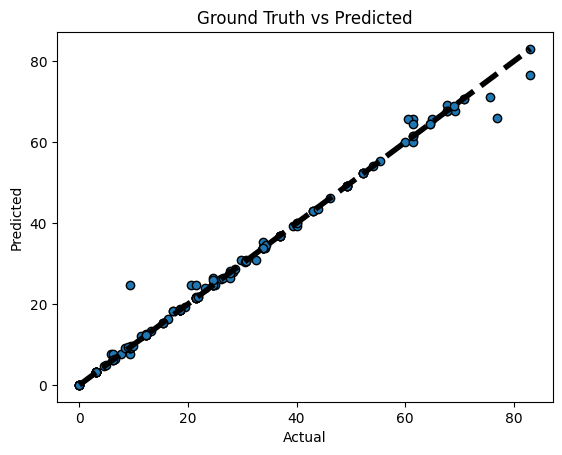

In [ ]:
fig, ax = plt.subplots()
ax.scatter(yt, y_predicted_train, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Ground Truth vs Predicted")
plt.show()

Permutation explainer: 161it [02:30,  1.06it/s]


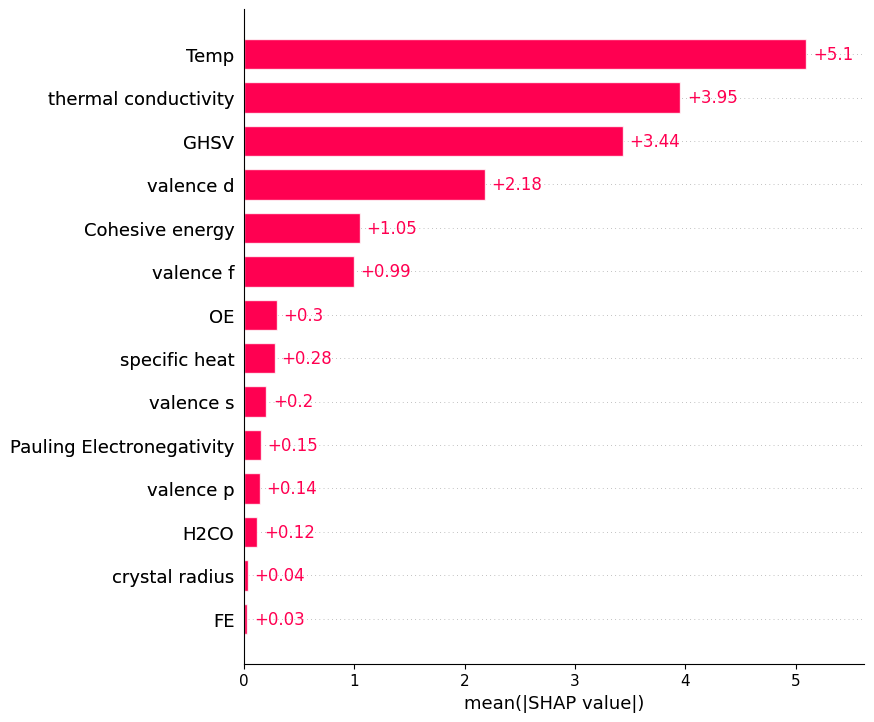

In [ ]:
explainer = shap.Explainer(model_SVR.predict, Xt)
shap_values = explainer(Xt)
shap.plots.bar(shap_values, max_display=15)

# Gaussian Process with RationalQuadratic kernel

In [15]:
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RationalQuadratic(length_scale=1.0, 
                              alpha=0.1) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))
model_GP = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.1, random_state=0)
model_GP.fit(Xt, yt)

#Measure the R2 for training and test set
print("The training R2 is: ", model_GP.score(Xt, yt))
print("The test R2 is: ", model_GP.score(X_test, y_test))

y_predicted_train = model_GP.predict(Xt)
y_predicted_test = model_GP.predict(X_test)

# The mean squared error & Variance
print("MSE of train set: %.2f"% mean_squared_error(yt, y_predicted_train))
print("RMSE of train set: %.2f"% sqrt(mean_squared_error(yt, y_predicted_train)))

print("MSE of test set: %.2f"% mean_squared_error(y_test, y_predicted_test))
print("RMSE of test set: %.2f"% sqrt(mean_squared_error(y_test, y_predicted_test)))

The training R2 is:  0.9961454963325943
The test R2 is:  0.9130148475523616
MSE of train set: 1.63
RMSE of train set: 1.28
MSE of test set: 34.17
RMSE of test set: 5.85


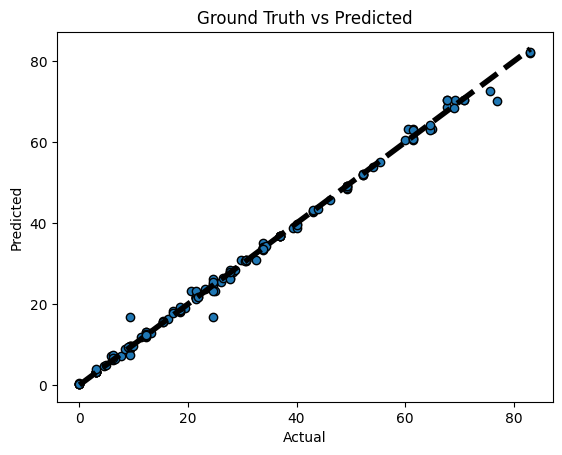

In [16]:
fig, ax = plt.subplots()
ax.scatter(yt, y_predicted_train, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Ground Truth vs Predicted")
plt.show()

Permutation explainer: 161it [04:21,  1.66s/it]


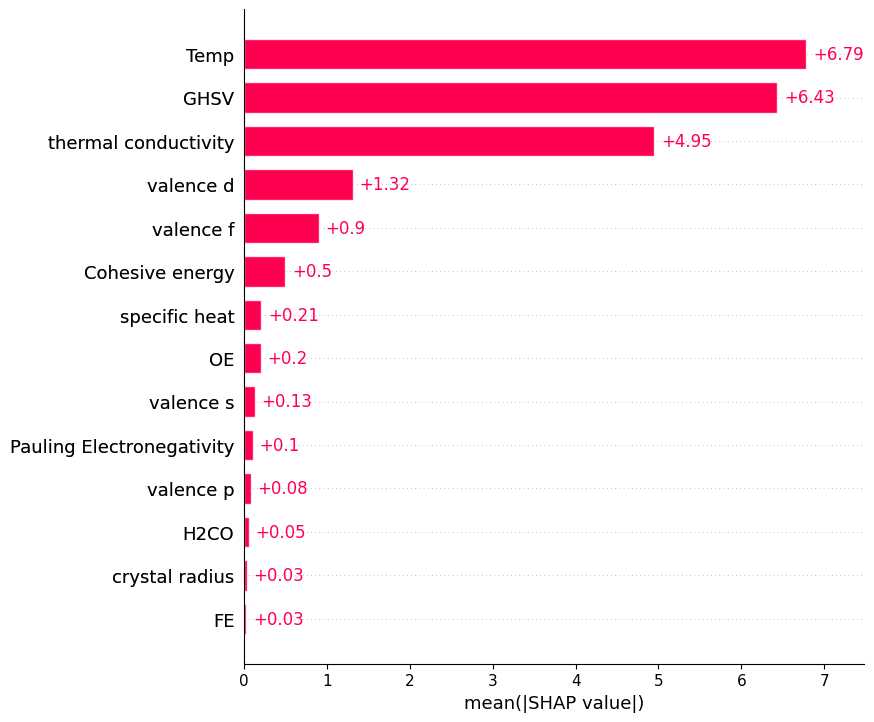

In [17]:
explainer = shap.Explainer(model_GP.predict, Xt)
shap_values = explainer(Xt)
shap.plots.bar(shap_values, max_display=15)